# Time-resolved fitting with RL


Run 189245: 0.6V to 0.1V

In [7]:
import sys
import os
import numpy as np
np.random.seed(42)

import json

from matplotlib import pyplot as plt

%matplotlib inline


import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)


## Set up the environment

In [9]:
import rl_model


initial_state_expt_file = os.path.join(git_dir, 'data', '189237-v2-expt.json')
final_state_expt_file = os.path.join(git_dir, 'data', '189246-v2-expt.json')

data_file = os.path.join(git_dir, 'data', 'r189245-time-resolved.json')
#ec_cp1 = np.loadtxt(os.path.join(project_dir, 'ec-data', 'Expt6_Summary_CP1.txt'), delimiter=',', skiprows=1).T


with open(data_file) as fd:
    m = json.load(fd)
    timestamps = np.asarray(m['times'])
    _data = m['data']
    print("Number of times: %s" % len(_data))
    

REVERSE = False
  
# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=_data, reverse=REVERSE)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()


Number of times: 25
0


## View the initial time and check that the initial model makes sense

reward: -1.3508732405538177
[0.22399089 0.30616811 0.58477861]


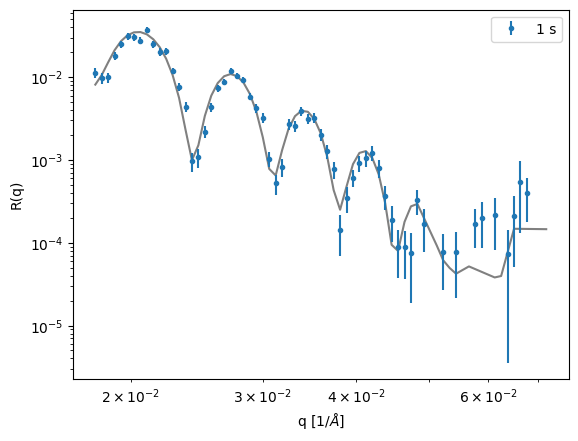

In [10]:
# choose a random action or use our initial fit
if False:
    action = env.action_space.sample() 
else:
    action = env.normalized_parameters

# take the action and get the information from the environment
new_state, reward, terminated, truncated, info = env.step(action)
print("reward: %s" % reward)
# show the current position and reward
env.render(action=action, reward=reward) 
env.plot(errors=True)

## Train or load model

In [ ]:
%%time

from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path="./logs-06-to-01-fwd-2025/",
    name_prefix="rl_model-forward",
    save_replay_buffer=False,
    save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)

if True:
    #model.learn(2000)
    model.learn(200, callback=checkpoint_callback)
    model.save('UIUC-06-to-01-SAC-forward')
else:
    model = SAC.load('UIUC-06-to-01-SAC-forward')

CPU times: user 3.11 s, sys: 2.61 s, total: 5.72 s
Wall time: 6.37 s


# Compute uncertainties

In [27]:
# There's likely a way to dig into the SAC parameters and fish out the action standard deviations

deltas = env.high_array - env.low_array

samples = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)


samples = np.asarray(samples).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

(3, 25, 100)
(3, 25)


## Run the agent on the time series data

In [28]:
# Evaluate the agent

episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    chi2.append(env.chi2)
    new_obs, reward, terminated, truncated, info = env.step(action)  
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (timestamps[i], obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)

Number of times: 25
Time 0 [0.]: -1.34958 [False] -1.34958
Time 60 [0.04166667]: -1.93787 [False] -3.28746
Time 120 [0.08333334]: -2.30319 [False] -5.59065
Time 180 [0.125]: -1.47201 [False] -7.06267
Time 240 [0.16666667]: -2.06765 [False] -9.13031
Time 300 [0.20833333]: -2.12339 [False] -11.2537
Time 360 [0.25]: -1.74395 [False] -12.9976
Time 420 [0.29166666]: -1.41378 [False] -14.4114
Time 480 [0.33333334]: -2.13109 [False] -16.5425
Time 540 [0.375]: -1.99295 [False] -18.5355
Time 600 [0.41666666]: -1.43421 [False] -19.9697
Time 660 [0.45833334]: -2.37176 [False] -22.3414
Time 720 [0.5]: -1.78434 [False] -24.1258
Time 780 [0.5416667]: -2.01271 [False] -26.1385
Time 840 [0.5833333]: -1.9316 [False] -28.0701
Time 900 [0.625]: -2.10069 [False] -30.1708
Time 960 [0.6666667]: -1.64138 [False] -31.8122
Time 1020 [0.7083333]: -1.87021 [False] -33.6824
Time 1080 [0.75]: -1.77061 [False] -35.453
Time 1140 [0.7916667]: -1.77704 [False] -37.23
Time 1200 [0.8333333]: -2.37701 [False] -39.607
Tim

## Plot the results and compare to the Bayesian approach

['Solvent interface', 'PVF thickness', 'PVF rho']


Text(0.5, 0, 'time [seconds]')

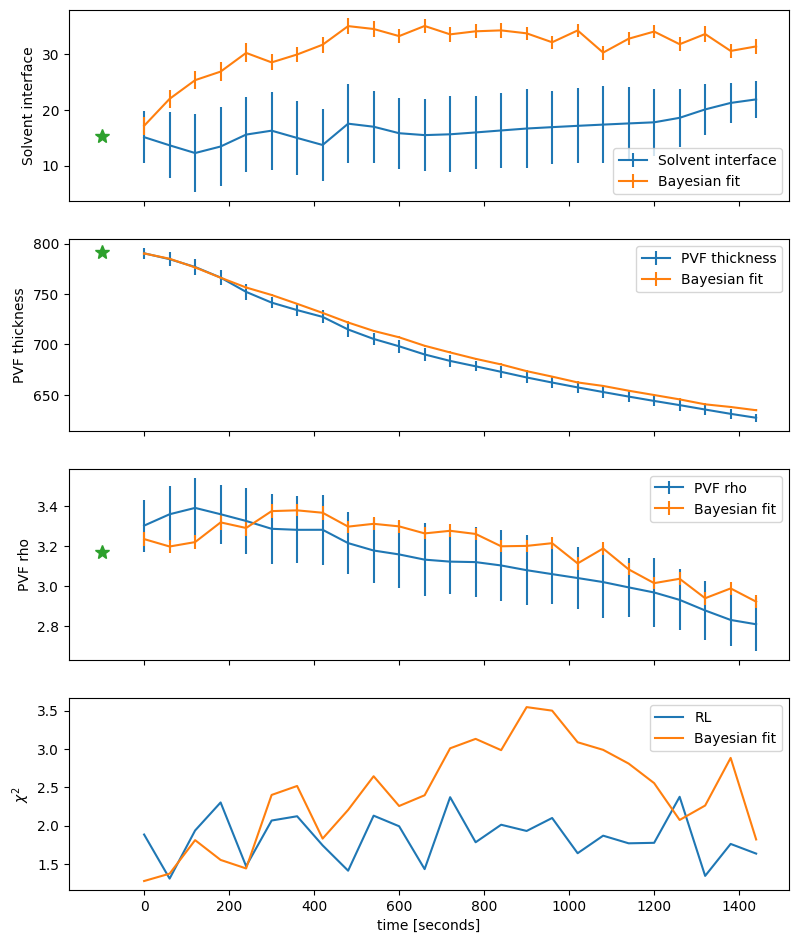

In [29]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T

# Bayesian fit trend
with open(os.path.join(git_dir, 'data', '189245-bayes-forward.json')) as fd:
    bayes_fits = json.load(fd)

t_delay = 100
if REVERSE:
    t_initial = timestamps[-1]+t_delay
    t_final = -t_delay
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+t_delay
    t_initial = -t_delay
    _times = timestamps

n_times = len(env.data)

fig, axs = plt.subplots(4,1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(4, 1, i+1)
    
    plt.errorbar(_times, pars[i], yerr=errs[i], label=env.par_labels[i])

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(_times, values, yerr=d_values, label='Bayesian fit')
    
    plt.plot([t_initial,], [env.parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(4, 1, i+1)
plt.plot(_times, chi2, label = 'RL')
plt.plot(_times, bayes_fits['chi2'], label = 'Bayesian fit')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

## Nicer plot

['Solvent interface', 'PVF thickness', 'PVF rho']


Text(0.5, 0, 'Time [seconds]')

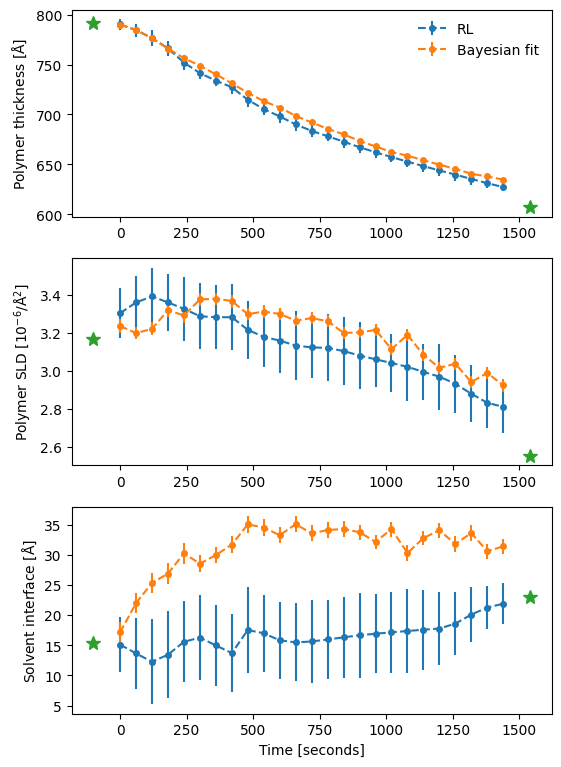

In [30]:

fig, axs = plt.subplots(3,1, dpi=100, figsize=(6,8), sharex=False)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)

axes = ['Solvent interface [$\mathrm{\AA}$]',
        'Polymer thickness [$\mathrm{\AA}$]',
        'Polymer SLD [$10^{-6}/\mathrm{\AA}^2$]']

position = 0
for i in [1,2,0]:
    position += 1
    ax = plt.subplot(3, 1, position)
    
    plt.errorbar(_times, pars[i], yerr=errs[i], label='RL', marker='.', markersize=8, linestyle='--')

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(_times, values, yerr=d_values, label='Bayesian fit', marker='.', markersize=8, linestyle='--')
    
    plt.plot([t_initial, t_final], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(axes[i])
    if i==1:
        plt.legend(frameon=False)

plt.xlabel("Time [seconds]")


Number of times: 25


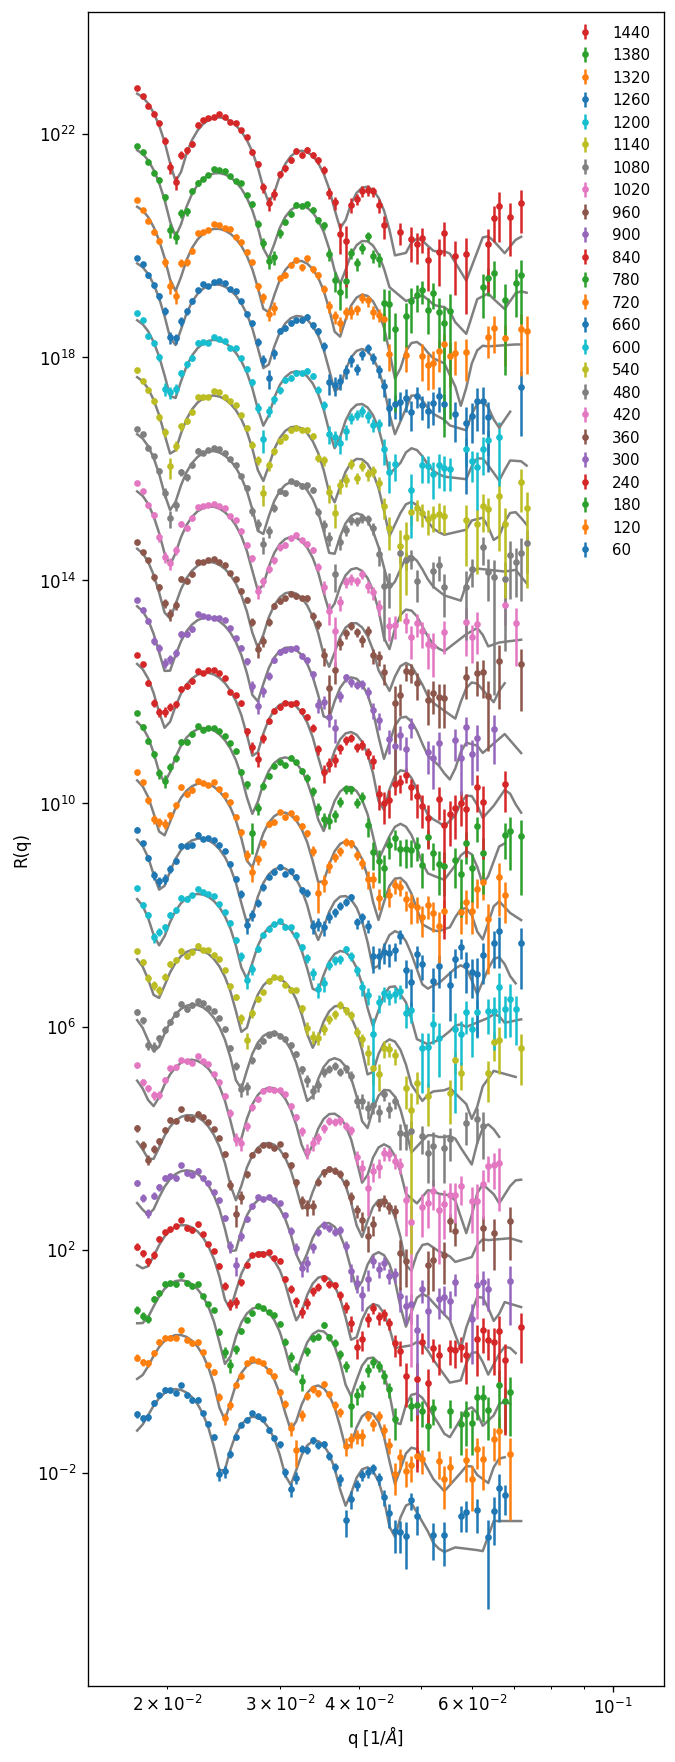

In [31]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig, ax = plt.subplots(dpi=120, figsize=(6, 15))
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.05)

for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)

    env.plot(scale=10.**i, newfig=False, errors=True, label=_times[i])

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], frameon=False, prop={'size': 9}, loc='upper right')
plt.xlim([0.015, 0.12])
plt.show()

# Training progression

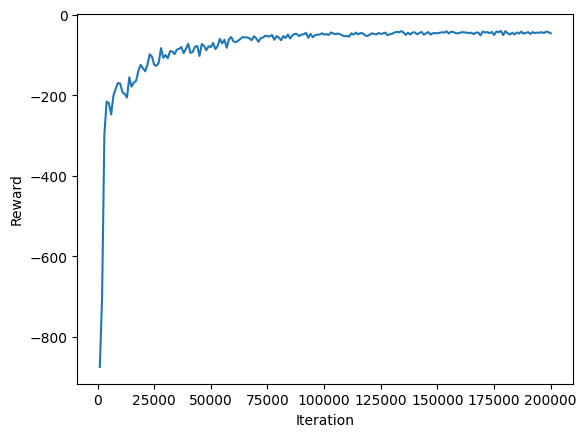

In [5]:
log_dir = "./logs-forward-no-final-state/"
log_dir = "./logs-06-to-01-fwd-2025/"
_dir_list = os.listdir(log_dir)

def evaluate(model):
    episode_reward = 0
    n_times = len(env.data)
    obs, info = env.reset()

    chi2 = 0
    for i in range(n_times):
        action, _ = model.predict(obs, deterministic=True)
        chi2 += env.chi2
        obs, reward, terminated, truncated, info = env.step(action)  
        episode_reward += reward
    return episode_reward

itr_list = []
reward_list = []

for file in _dir_list:
    model = SAC.load(os.path.join(log_dir, file))
    reward = evaluate(model)
    iteration = int(file.replace("rl_model-forward_", "").replace("_steps.zip", ""))
    itr_list.append(iteration)
    reward_list.append(reward)

itr_list = np.asarray(itr_list)
reward_list = np.asarray(reward_list)
idx = itr_list.argsort()

fig = plt.figure(dpi=100)
plt.plot(itr_list[idx], reward_list[idx])
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.show()
        